In [85]:
from typing import Optional, Union
from itertools import product
import numpy as np
import pandas as pd
import qiskit.providers.fake_provider as fp
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit.library import QFT

In [114]:
def make_circuit(eval_qubit: int,
                 barrier: Optional[bool] = False,
                 measure: Optional[bool] = False) -> QuantumCircuit:
    eval_qubit = eval_qubit
    total_qubit = eval_qubit + 1  # eval + target qubit 1개

    p = 0.34
    theta_p = 2 * np.arcsin(np.sqrt(p))  # QAA의 A를 만들기 위한 Ry 각도
    theta_for_q = 2 * theta_p  # Q의 각도

    qreg_q = QuantumRegister(total_qubit, 'q')
    creg_c = ClassicalRegister(total_qubit - 1, 'c')  # 하나 없어도 되나?
    circuit = QuantumCircuit(qreg_q, creg_c)

    circuit.h(qreg_q[0:eval_qubit])
    circuit.ry(theta_p, qreg_q[eval_qubit])
    if barrier:
        circuit.barrier()

    for i in range(eval_qubit):
        circuit.cry(theta_for_q * (2 ** (eval_qubit - 1 - i)), qreg_q[i], qreg_q[eval_qubit])
        if barrier:
            circuit.barrier()

    circuit.append(QFT(eval_qubit, inverse=True, do_swaps=False),
                   qreg_q[0:eval_qubit])
    if barrier:
        circuit.barrier()
    if measure:
        for i in range(eval_qubit):
            circuit.measure(qreg_q[i], creg_c[i])

    return circuit

In [115]:
def transpile_circuit(circuit: QuantumCircuit, type: str) -> QuantumCircuit:
    if type == 'ionq':
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['rx', 'ry', 'rz', 'rxx', 'id'])
    if type == 'ibm_ideal':
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['cx', 'id', 'rz', 'x', 'sx'])
    if type == 'ibm_yorktown':
        backend = fp.FakeYorktown()
        if circuit.num_qubits > backend.configuration().n_qubits:
            return QuantumCircuit(1,1)
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['cx', 'id', 'rz', 'x', 'sx'],
                                       backend=backend)
    if type == 'ibm_tokyo':
        backend = fp.FakeTokyo()
        if circuit.num_qubits > backend.configuration().n_qubits:
            return QuantumCircuit(1,1)
        transpiled_circuit = transpile(circuit,
                                       basis_gates=['cx', 'id', 'rz', 'x', 'sx'],
                                       backend=backend)

    return transpiled_circuit

In [116]:
circuit = make_circuit(eval_qubit=4, barrier=True, measure=True)

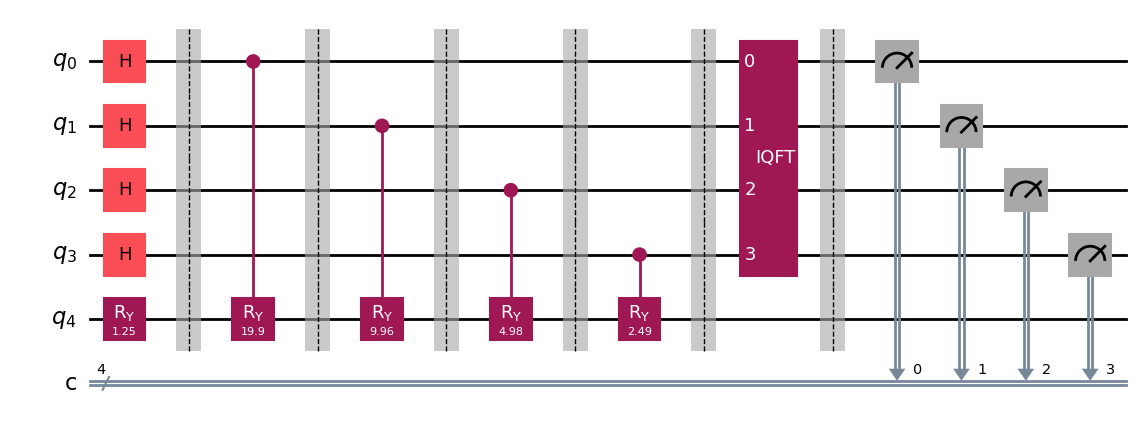

In [117]:
circuit.draw(output='mpl', style="iqp")

In [118]:
transpiled_circuit = transpile_circuit(circuit=circuit, type='ionq')

In [119]:
transpiled_circuit.depth()

61

In [120]:
circuit_setting = {"eval_qubit": [2, 3, 4, 5, 6, 7],
                   "barrier": [True, False],
                   "measure": [True, False],}
transpile_setting = ['ionq', 'ibm_ideal', 'ibm_yorktown', 'ibm_tokyo']

In [152]:
result = pd.DataFrame(columns=['eval_qubit','barrier','measure','device','depth'])
for combo in product(*circuit_setting.values()):
    circuit = make_circuit(*combo)
    for type in transpile_setting:
        transpiled_circuit = transpile_circuit(circuit=circuit, type=type)
        depth = transpiled_circuit.depth()
        result.loc[len(result)] = [*combo, type, depth]

In [155]:
result

,eval_qubit,barrier,measure,device,depth
0,2,True,True,ionq,25
1,2,True,True,ibm_ideal,34
2,2,True,True,ibm_yorktown,34
3,2,True,True,ibm_tokyo,34
4,2,True,False,ionq,24
...,...,...,...,...,...
91,7,False,True,ibm_tokyo,149
92,7,False,False,ionq,73
93,7,False,False,ibm_ideal,97
94,7,False,False,ibm_yorktown,0


In [156]:
result.to_csv('result.csv')

In [158]:
#결과 plot하기
#transpile 최소값 해야하나?